<a href="https://colab.research.google.com/github/p25-c4/kurly_project/blob/main/0318_HY_RFM3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting

In [ ]:
!nvidia-smi

Fri Mar 15 13:32:32 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [1]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq
!rm ~/.cache/matplotlib -rf

Selecting previously unselected package fonts-nanum.
(Reading database ... 121752 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Setting up fonts-nanum-coding (2.5-3) ...
Setting up fonts-nanum-eco (1.000-7) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [1]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir("/content/drive/MyDrive/BigData/early_project")

In [3]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

palette = sns.color_palette('Purples')
palette.reverse()

sns.set_palette("Purples")

In [4]:
# 한글폰트 설정
mpl.rc("font",family = "NanumGothic")
mpl.rc("axes", unicode_minus = False)

# Data load

In [4]:
# 파일 불러오는 코드
import pandas as pd
import zipfile
import io

# ZIP 파일 경로
zip_file_path = 'kurly.zip'
# ZIP 파일 열기
with zipfile.ZipFile(zip_file_path) as z:
    # ZIP 파일 내에서 'total.csv' 찾기
    with z.open('kurly.csv') as csv_file:
        # CSV 파일을 Pandas DataFrame으로 읽기
        kurly = pd.read_csv(csv_file)

In [5]:
# OrderDT 열을 datetime 객체로 변환
kurly['OrderDT'] = pd.to_datetime(kurly['OrderDT'], format='%Y-%m-%d %H:%M:%S')

# datetime 객체에서 년을 추출하여 새로운 컬럼 Month에 저장
kurly['Year'] = kurly['OrderDT'].dt.year
# datetime 객체에서 월을 추출하여 새로운 컬럼 Month에 저장
kurly['Month'] = kurly['OrderDT'].dt.month
# datetime 객체에서 일을 추출하여 새로운 컬럼 Month에 저장
kurly['Day'] = kurly['OrderDT'].dt.day
# datetime 객체에서 시를 추출하여 새로운 컬럼 Month에 저장
kurly['Hour'] = kurly['OrderDT'].dt.hour


---

# RFM (고객 세분화 분석)

우선 전체기간 rfm 결과를 등급선정의 기준으로 세운 다음, 연도별로 rfm을 재수행하여 차이가 있는지 비교해보기로 한다.

## 전체기간 RFM

In [6]:
# 고객 세그먼트 분류 함수
def calcurate_customer_score(row):
    R, F, M = row['R_Score'], row['F_Score'], row['M_Score']
    segment_score = 0.1*R + 0.4*F +0.5*M
    return segment_score

In [7]:
# 원본 데이터셋 복사
rfm_online_sales =  kurly.copy()
# 데이터 내 마지막 날짜 계산
last_date = rfm_online_sales['OrderDT'].max()

# Recency 계산
recency_data = rfm_online_sales.groupby('idUser')['OrderDT'].max().reset_index()
recency_data['Recency'] = (last_date - recency_data['OrderDT']).dt.days

# Frequency 계산
frequency_data = rfm_online_sales.groupby('idUser')['idOrder'].nunique().reset_index()
frequency_data.rename(columns={'idOrder': 'Frequency'}, inplace=True)

# Monetary 계산
monetary_data = rfm_online_sales.groupby('idUser')['Price'].sum().reset_index()
monetary_data.rename(columns={'Price': 'Monetary'}, inplace=True)

# RFM 데이터 결합
rfm_data = recency_data.merge(frequency_data, on='idUser').merge(monetary_data, on='idUser')

# Recency, Frequency, Monetary에 점수 부여
rfm_data['R_Score'] = pd.qcut(rfm_data['Recency'], 4, labels=[4, 3, 2, 1])
rfm_data['F_Score'] = pd.qcut(rfm_data['Frequency'], 4, labels=[1, 2, 3, 4])
rfm_data['M_Score'] = pd.qcut(rfm_data['Monetary'], 4, labels=[1, 2, 3, 4])

# rfm_data에 'Customer_Score' 컬럼 추가
rfm_data['Customer_Score'] = rfm_data.apply(calcurate_customer_score, axis=1)

In [8]:
rfm_data_counts = rfm_data.value_counts('Customer_Score').sort_index()
rfm_data_counts = pd.DataFrame(rfm_data_counts)
rfm_data_counts.reset_index(inplace=True)
rfm_data_counts.rename(columns={'Customer_Score': 'Score',0: 'counts'}, inplace=True)

# counts의 누적합 계산
total_counts = rfm_data_counts['counts'].sum()
# 누적 비율 컬럼 추가
rfm_data_counts['cumulative_ratio'] = (rfm_data_counts['counts'].cumsum() / total_counts).round(3)

print(rfm_data_counts.sort_values(by='Score',ascending=False))


    Score  counts  cumulative_ratio
34    4.0     202             1.000
33    3.9     163             0.933
32    3.8     136             0.878
31    3.7     117             0.833
30    3.6      42             0.794
29    3.5      61             0.780
28    3.4      56             0.760
27    3.3      21             0.741
26    3.3      19             0.734
25    3.2      29             0.728
24    3.1     114             0.718
23    3.0     136             0.680
22    2.9     105             0.635
21    2.9       1             0.600
20    2.8     121             0.599
19    2.7      58             0.559
18    2.6      67             0.540
17    2.5      65             0.517
16    2.4      30             0.496
15    2.4      48             0.486
14    2.3      30             0.470
13    2.3       2             0.460
12    2.2     115             0.459
11    2.1     136             0.421
10    2.0     126             0.375
9     1.9     148             0.333
8     1.8      28           

**등급 기준**  
누적비율  
상위 20% -> no.1  : Score 기준 3.6 이상  
상위 50% -> no.2  : Score 기준 2.4 이상  
상위 90% -> no.3  : Score 기준 1.1 이상  
상위 100% -> no.4


In [40]:
# 고객 세그먼트 분류 함수
def classify_customer_segment(row):
    R, F, M = row['R_Score'], row['F_Score'], row['M_Score']
    segment_score = 0.1*R + 0.4*F +0.5*M

    if segment_score >= 3.6:
      return '숲'
    elif segment_score >= 2.4:
      return '나무'
    elif segment_score >= 1.1:
      return '새싹'
    else :
      return '씨앗'

In [41]:

# rfm_data에 'Customer_Segment' 컬럼 추가
rfm_data['Customer_Segment'] = rfm_data.apply(classify_customer_segment, axis=1)

# 가능한 모든 세그먼트 정의
all_segments = ['숲','나무','새싹','씨앗']

# 각 세그먼트별 고객 수 계산
segment_counts = rfm_data['Customer_Segment'].value_counts()

# 모든 세그먼트에 대한 고객 수를 0으로 초기화하고, 계산된 값으로 업데이트
segment_counts_all = {segment: 0 for segment in all_segments}
segment_counts_all.update(segment_counts)

# 데이터프레임으로 변환
segment_counts_df = pd.DataFrame(list(segment_counts_all.items()), columns=['Segment', 'Count'])
segment_counts_df

# 세그먼트별 고객 수를 내림차순으로 정렬
segment_counts_sorted_df = segment_counts_df.sort_values(by='Count', ascending=False)

## 3개월 별 RFM (21.1~23.12)

In [42]:
def rfm_segment_counts(data, start_year, start_month):
    # 원본 데이터셋 복사
    rfm_online_sales = data[(data['Year'] == start_year) & ((data['Month'] ==  start_month) | (data['Month'] ==  start_month+1) | (data['Month'] ==  start_month+2))].copy()
    # 데이터 내 마지막 날짜 계산
    last_date = rfm_online_sales['OrderDT'].max()

    # Recency 계산
    recency_data = rfm_online_sales.groupby('idUser')['OrderDT'].max().reset_index()
    recency_data['Recency'] = (last_date - recency_data['OrderDT']).dt.days

    # Frequency 계산
    frequency_data = rfm_online_sales.groupby('idUser')['idOrder'].nunique().reset_index()
    frequency_data.rename(columns={'idOrder': 'Frequency'}, inplace=True)

    # Monetary 계산
    monetary_data = rfm_online_sales.groupby('idUser')['Price'].sum().reset_index()
    monetary_data.rename(columns={'Price': 'Monetary'}, inplace=True)

    # RFM 데이터 결합
    rfm_data = recency_data.merge(frequency_data, on='idUser').merge(monetary_data, on='idUser')

    # Recency, Frequency, Monetary에 점수 부여
    rfm_data['R_Score'] = pd.qcut(rfm_data['Recency'], 4, labels=[4, 3, 2, 1])
    rfm_data['F_Score'] = pd.qcut(rfm_data['Frequency'], 4, labels=[1, 2, 3, 4])
    rfm_data['M_Score'] = pd.qcut(rfm_data['Monetary'], 4, labels=[1, 2, 3, 4])

    # rfm_data에 'Customer_Segment' 컬럼 추가
    rfm_data['Customer_Segment'] = rfm_data.apply(classify_customer_segment, axis=1)

    # 각 세그먼트별 고객 수 계산
    segment_counts = rfm_data['Customer_Segment'].value_counts()

    # 모든 세그먼트에 대한 고객 수를 0으로 초기화하고, 계산된 값으로 업데이트
    segment_counts_all = {segment: 0 for segment in all_segments}
    segment_counts_all.update(segment_counts)

    # 데이터프레임으로 변환
    segment_counts_df = pd.DataFrame(list(segment_counts_all.items()), columns=['Segment', 'Count'])

    # 세그먼트별 고객 수를 내림차순으로 정렬
    segment_counts_sorted_df = segment_counts_df.sort_values(by='Count', ascending=False)
    return rfm_data

In [43]:
# 결과를 저장할 빈 데이터프레임 생성
rfm_result_df = pd.DataFrame(columns=['idUser'])
rfm_result_df['idUser'] = kurly['idUser'].drop_duplicates(keep='first')

# 2021년 1월부터 2023년 12월까지의 데이터 분석
for year in range(2021, 2024):
    for month in range(1, 13, 3):
        # 해당 연도와 월에 대한 결과 계산
        rfm_result = rfm_segment_counts(kurly, year, month)
        column_name = f"Segment_{year}_{month}"

        # 결과를 데이터프레임에 추가
        rfm_result_df = pd.concat([rfm_result_df.set_index('idUser'), rfm_result.set_index('idUser')['Customer_Segment']], axis=1, sort=False).reset_index()
        rfm_result_df.rename(columns={'Customer_Segment': column_name}, inplace=True)

rfm_result_df

,idUser,Segment_2021_1,Segment_2021_4,Segment_2021_7,Segment_2021_10,Segment_2022_1,Segment_2022_4,Segment_2022_7,Segment_2022_10,Segment_2023_1,Segment_2023_4,Segment_2023_7,Segment_2023_10
0,U10001,숲,숲,새싹,새싹,나무,숲,나무,새싹,새싹,새싹,새싹,나무
1,U10002,나무,새싹,나무,나무,새싹,새싹,씨앗,새싹,새싹,새싹,나무,새싹
2,U10003,NaN,NaN,NaN,NaN,나무,나무,나무,나무,나무,숲,숲,새싹
3,U10004,나무,나무,나무,나무,NaN,NaN,NaN,NaN,새싹,새싹,씨앗,씨앗
4,U10005,새싹,새싹,새싹,숲,숲,숲,나무,새싹,숲,새싹,숲,새싹
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,U12996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,나무,새싹,나무,새싹
2996,U12997,새싹,나무,숲,숲,씨앗,새싹,씨앗,나무,나무,나무,숲,나무
2997,U12998,나무,새싹,새싹,NaN,씨앗,씨앗,숲,새싹,씨앗,숲,나무,새싹
2998,U12999,나무,숲,새싹,새싹,새싹,씨앗,나무,새싹,새싹,새싹,숲,새싹


**결과값 데이터 파일명 rfm_result_df**

In [64]:
rfm_result_df['Segment_2021_1'].value_counts().reindex(['숲', '나무', '새싹', '씨앗'])

숲     420
나무    901
새싹    956
씨앗    246
Name: Segment_2021_1, dtype: int64

Segment_2021_1  Segment_2021_4  Segment_2021_7  Segment_2021_10  Segment_2022_1  Segment_2022_4  Segment_2022_7  Segment_2022_10  Segment_2023_1  Segment_2023_4  Segment_2023_7  Segment_2023_10
새싹              새싹              나무              새싹               새싹              씨앗              나무              나무               나무              새싹              숲               나무                 2
나무              나무              나무              나무               나무              나무              숲               새싹               숲               숲               새싹              숲                  1
새싹              숲               새싹              숲                새싹              숲               나무              새싹               새싹              새싹              새싹              나무                 1
                                                                 숲               나무              새싹              숲                나무              나무              나무              새싹                 1
          

### 고객별 등급 변동지수

In [52]:
# 각 세그먼트를 숫자로 변환하는 함수 정의
def segment_to_numeric(segment):
    if segment == '숲':
        return 1
    elif segment == '나무':
        return 2
    elif segment == '새싹':
        return 3
    elif segment == '씨앗':
        return 4
    else:
        return np.nan

# 각 컬럼에 대해 숫자로 변환 적용
merge_rfm_var = rfm_result_df.copy()
for col in merge_rfm_var.columns:
    merge_rfm_var[col] = merge_rfm_var[col].apply(segment_to_numeric)

merge_rfm_var.head()

,idUser,Segment_2021_1,Segment_2021_4,Segment_2021_7,Segment_2021_10,Segment_2022_1,Segment_2022_4,Segment_2022_7,Segment_2022_10,Segment_2023_1,Segment_2023_4,Segment_2023_7,Segment_2023_10
0,NaN,1.0,1.0,3.0,3.0,2.0,1.0,2.0,3.0,3.0,3.0,3.0,2.0
1,NaN,2.0,3.0,2.0,2.0,3.0,3.0,4.0,3.0,3.0,3.0,2.0,3.0
2,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.0,2.0,2.0,1.0,1.0,3.0
3,NaN,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,3.0,3.0,4.0,4.0
4,NaN,3.0,3.0,3.0,1.0,1.0,1.0,2.0,3.0,1.0,3.0,1.0,3.0


In [53]:
# 변동 지수 계산 함수 정의
def variability_index(row):
    # 해당 유저의 Customer Segment 데이터 추출
    segments = row[[col for col in rfm_result_df.columns if 'Segment' in col]]

    # 표준편차와 평균 계산
    std_dev = np.std(segments)
    mean = np.mean(segments)

    # 변동 지수 계산
    return (std_dev / mean).round(3)

# 각 유저의 변동 지수 계산
merge_rfm_var['Variability'] = merge_rfm_var.apply(variability_index, axis=1)

merge_rfm_var.sort_values('Variability', ascending=False).head(10)

,idUser,Segment_2021_1,Segment_2021_4,Segment_2021_7,Segment_2021_10,Segment_2022_1,Segment_2022_4,Segment_2022_7,Segment_2022_10,Segment_2023_1,Segment_2023_4,Segment_2023_7,Segment_2023_10,Variability
2580,NaN,1.0,1.0,3.0,1.0,NaN,NaN,NaN,NaN,4.0,1.0,1.0,4.0,0.661
2604,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,2.0,3.0,1.0,4.0,1.0,0.623
1900,NaN,NaN,NaN,NaN,NaN,2.0,1.0,1.0,4.0,4.0,1.0,2.0,1.0,0.612
2502,NaN,NaN,NaN,NaN,NaN,4.0,2.0,1.0,4.0,1.0,1.0,1.0,2.0,0.612
1261,NaN,NaN,NaN,NaN,NaN,4.0,2.0,1.0,3.0,NaN,1.0,1.0,1.0,0.606
2894,NaN,1.0,1.0,4.0,NaN,2.0,1.0,1.0,4.0,2.0,NaN,2.0,1.0,0.598
128,NaN,4.0,3.0,1.0,2.0,4.0,1.0,3.0,1.0,4.0,1.0,1.0,1.0,0.591
2223,NaN,3.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,4.0,4.0,0.582
2963,NaN,NaN,NaN,NaN,NaN,1.0,2.0,4.0,NaN,4.0,1.0,2.0,1.0,0.581
1770,NaN,1.0,4.0,4.0,NaN,1.0,1.0,1.0,2.0,4.0,3.0,1.0,2.0,0.580


### kurly 데이터와 병합

In [54]:
Kurly = pd.merge(kurly,rfm_result_df,on='idUser')

In [55]:
Kurly.head()

,idUser,idOrder,OrderDT,ItemCode,Price,DeliveryDT,Delay_YN,ItemLargeCode,ItemLargeName,ItemMiddleCode,...,Segment_2021_7,Segment_2021_10,Segment_2022_1,Segment_2022_4,Segment_2022_7,Segment_2022_10,Segment_2023_1,Segment_2023_4,Segment_2023_7,Segment_2023_10
0,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L1-M12-S0070-1113,17030,2021-12-04 03:26:00,0,L1,가공식품,M12,...,새싹,새싹,나무,숲,나무,새싹,새싹,새싹,새싹,나무
1,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L1-M15-S0140-1247,7680,2021-12-04 03:26:00,0,L1,가공식품,M15,...,새싹,새싹,나무,숲,나무,새싹,새싹,새싹,새싹,나무
2,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L1-M23-S0580-1047,12420,2021-12-04 03:26:00,0,L1,가공식품,M23,...,새싹,새싹,나무,숲,나무,새싹,새싹,새싹,새싹,나무
3,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L4-M12-S0640-1010,6250,2021-12-04 03:26:00,0,L4,신선식품,M12,...,새싹,새싹,나무,숲,나무,새싹,새싹,새싹,새싹,나무
4,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L4-M17-S0130-1018,14450,2021-12-04 03:26:00,0,L4,신선식품,M17,...,새싹,새싹,나무,숲,나무,새싹,새싹,새싹,새싹,나무


## 연도별 RFM

### 2021 RFM

In [ ]:
# 원본 데이터셋 복사
rfm_online_sales =  kurly[kurly['Year']==2021].copy()
# 데이터 내 마지막 날짜 계산
last_date = rfm_online_sales['OrderDT'].max()

# Recency 계산
recency_data = rfm_online_sales.groupby('idUser')['OrderDT'].max().reset_index()
recency_data['Recency'] = (last_date - recency_data['OrderDT']).dt.days

# Frequency 계산
frequency_data = rfm_online_sales.groupby('idUser')['idOrder'].nunique().reset_index()
frequency_data.rename(columns={'idOrder': 'Frequency'}, inplace=True)

# Monetary 계산
monetary_data = rfm_online_sales.groupby('idUser')['Price'].sum().reset_index()
monetary_data.rename(columns={'Price': 'Monetary'}, inplace=True)

# RFM 데이터 결합
rfm_data_21 = recency_data.merge(frequency_data, on='idUser').merge(monetary_data, on='idUser')

# Recency, Frequency, Monetary에 점수 부여
rfm_data_21['R_Score'] = pd.qcut(rfm_data_21['Recency'], 4, labels=[4, 3, 2, 1])
rfm_data_21['F_Score'] = pd.qcut(rfm_data_21['Frequency'], 4, labels=[1, 2, 3, 4])
rfm_data_21['M_Score'] = pd.qcut(rfm_data_21['Monetary'], 4, labels=[1, 2, 3, 4])

# rfm_data에 'Customer_Segment' 컬럼 추가
rfm_data_21['Customer_Segment_21'] = rfm_data_21.apply(classify_customer_segment, axis=1)

# 각 세그먼트별 고객 수 계산
segment_counts = rfm_data_21['Customer_Segment_21'].value_counts()

# 모든 세그먼트에 대한 고객 수를 0으로 초기화하고, 계산된 값으로 업데이트
segment_counts_all = {segment: 0 for segment in all_segments}
segment_counts_all.update(segment_counts)

# 데이터프레임으로 변환
segment_counts_df = pd.DataFrame(list(segment_counts_all.items()), columns=['Segment', 'Count'])

# 세그먼트별 고객 수를 내림차순으로 정렬
segment_counts_sorted_df_21 = segment_counts_df.sort_values(by='Count', ascending=False)


segment_counts_df

,Segment,Count
0,no.1,284
1,no.2,1102
2,no.3,947
3,no.4,199


In [ ]:
rfm_data

,idUser,OrderDT,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,Customer_Score,Customer_Segment
0,U10001,2023-12-27 08:25:54,4,69,5968480,4,4,4,4.0,no.1
1,U10002,2023-12-06 10:16:48,25,54,4595890,1,2,1,1.4,no.3
2,U10003,2023-12-23 21:09:58,8,53,5110930,3,2,2,2.2,no.3
3,U10004,2023-12-05 20:24:04,26,33,2641890,1,1,1,1.0,no.4
4,U10005,2023-11-20 12:40:36,41,79,6920530,1,4,4,3.4,no.2
...,...,...,...,...,...,...,...,...,...,...
2995,U12996,2023-12-29 18:56:12,2,20,2256990,4,1,1,1.6,no.3
2996,U12997,2023-12-26 20:27:53,5,67,5999100,3,3,4,3.4,no.2
2997,U12998,2023-11-27 19:51:55,34,56,5318240,1,2,3,2.2,no.3
2998,U12999,2023-12-27 10:22:26,4,55,5321330,4,2,3,2.8,no.2


### 2022 RFM

In [ ]:
# 원본 데이터셋 복사
rfm_online_sales =  kurly[kurly['Year']==2022].copy()
# 데이터 내 마지막 날짜 계산
last_date = rfm_online_sales['OrderDT'].max()

# Recency 계산
recency_data = rfm_online_sales.groupby('idUser')['OrderDT'].max().reset_index()
recency_data['Recency'] = (last_date - recency_data['OrderDT']).dt.days

# Frequency 계산
frequency_data = rfm_online_sales.groupby('idUser')['idOrder'].nunique().reset_index()
frequency_data.rename(columns={'idOrder': 'Frequency'}, inplace=True)

# Monetary 계산
monetary_data = rfm_online_sales.groupby('idUser')['Price'].sum().reset_index()
monetary_data.rename(columns={'Price': 'Monetary'}, inplace=True)

# RFM 데이터 결합
rfm_data_22 = recency_data.merge(frequency_data, on='idUser').merge(monetary_data, on='idUser')

# Recency, Frequency, Monetary에 점수 부여
rfm_data_22['R_Score'] = pd.qcut(rfm_data_22['Recency'], 4, labels=[4, 3, 2, 1])
rfm_data_22['F_Score'] = pd.qcut(rfm_data_22['Frequency'], 4, labels=[1, 2, 3, 4])
rfm_data_22['M_Score'] = pd.qcut(rfm_data_22['Monetary'], 4, labels=[1, 2, 3, 4])

# rfm_data에 'Customer_Segment' 컬럼 추가
rfm_data_22['Customer_Segment_22'] = rfm_data_22.apply(classify_customer_segment, axis=1)

# 각 세그먼트별 고객 수 계산
segment_counts = rfm_data_22['Customer_Segment_22'].value_counts()

# 모든 세그먼트에 대한 고객 수를 0으로 초기화하고, 계산된 값으로 업데이트
segment_counts_all = {segment: 0 for segment in all_segments}
segment_counts_all.update(segment_counts)

# 데이터프레임으로 변환
segment_counts_df = pd.DataFrame(list(segment_counts_all.items()), columns=['Segment', 'Count'])

# 세그먼트별 고객 수를 내림차순으로 정렬
segment_counts_sorted_df_22 = segment_counts_df.sort_values(by='Count', ascending=False)

segment_counts_df

,Segment,Count
0,no.1,328
1,no.2,1173
2,no.3,1065
3,no.4,245


In [ ]:
rfm_data_22

,idUser,OrderDT,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,Customer_Segment_22
0,U10001,2022-12-20 20:53:43,11,24,2085580,2,3,4,no.2
1,U10002,2022-12-30 16:51:47,1,13,1052540,4,1,1,no.3
2,U10003,2022-12-25 10:19:31,6,26,2272200,3,4,4,no.1
3,U10005,2022-12-20 08:19:44,11,30,2668180,2,4,4,no.2
4,U10006,2022-12-05 12:29:58,26,26,1834740,1,4,3,no.2
...,...,...,...,...,...,...,...,...,...
2806,U12995,2022-12-14 15:33:25,17,33,2807650,2,4,4,no.2
2807,U12997,2022-12-22 17:53:33,9,13,1172520,3,1,1,no.3
2808,U12998,2022-12-24 16:10:42,7,19,1694210,3,2,2,no.3
2809,U12999,2022-12-27 18:31:24,4,15,1566240,4,1,2,no.3


왜 2811??

### 2023 RFM

In [90]:
# 원본 데이터셋 복사
rfm_online_sales =  kurly[kurly['Year']==2023].copy()
# 데이터 내 마지막 날짜 계산
last_date = rfm_online_sales['OrderDT'].max()

# Recency 계산
recency_data = rfm_online_sales.groupby('idUser')['OrderDT'].max().reset_index()
recency_data['Recency'] = (last_date - recency_data['OrderDT']).dt.days

# Frequency 계산
frequency_data = rfm_online_sales.groupby('idUser')['idOrder'].nunique().reset_index()
frequency_data.rename(columns={'idOrder': 'Frequency'}, inplace=True)

# Monetary 계산
monetary_data = rfm_online_sales.groupby('idUser')['Price'].sum().reset_index()
monetary_data.rename(columns={'Price': 'Monetary'}, inplace=True)

# RFM 데이터 결합
rfm_data_23 = recency_data.merge(frequency_data, on='idUser').merge(monetary_data, on='idUser')

# Recency, Frequency, Monetary에 점수 부여
rfm_data_23['R_Score'] = pd.qcut(rfm_data_23['Recency'], 4, labels=[4, 3, 2, 1])
rfm_data_23['F_Score'] = pd.qcut(rfm_data_23['Frequency'], 4, labels=[1, 2, 3, 4])
rfm_data_23['M_Score'] = pd.qcut(rfm_data_23['Monetary'], 4, labels=[1, 2, 3, 4])

# rfm_data에 'Customer_Segment' 컬럼 추가
rfm_data_23['Customer_Segment_23'] = rfm_data_23.apply(classify_customer_segment, axis=1)

# 각 세그먼트별 고객 수 계산
segment_counts = rfm_data_23['Customer_Segment_23'].value_counts()

# 모든 세그먼트에 대한 고객 수를 0으로 초기화하고, 계산된 값으로 업데이트
segment_counts_all = {segment: 0 for segment in all_segments}
segment_counts_all.update(segment_counts)

# 데이터프레임으로 변환
segment_counts_df = pd.DataFrame(list(segment_counts_all.items()), columns=['Segment', 'Count'])

# 세그먼트별 고객 수를 내림차순으로 정렬
segment_counts_sorted_df_23 = segment_counts_df.sort_values(by='Count', ascending=False)

segment_counts_df

,Segment,Count
0,no.1,644
1,no.2,922
2,no.3,1185
3,no.4,249


In [91]:
frequency_data

,idUser,Frequency
0,U10001,18
1,U10002,19
2,U10003,27
3,U10004,10
4,U10005,27
...,...,...
2995,U12996,20
2996,U12997,26
2997,U12998,21
2998,U12999,19


In [ ]:
rfm_data_23

,idUser,OrderDT,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,Customer_Segment_23
0,U10001,2023-12-27 08:25:54,4,18,1772050,4,1,1,no.3
1,U10002,2023-12-06 10:16:48,25,19,2059370,1,2,2,no.3
2,U10003,2023-12-23 21:09:58,8,27,2838730,3,4,4,no.1
3,U10004,2023-12-05 20:24:04,26,10,950540,1,1,1,no.4
4,U10005,2023-11-20 12:40:36,41,27,2726100,1,4,4,no.2
...,...,...,...,...,...,...,...,...,...
2995,U12996,2023-12-29 18:56:12,2,20,2256990,4,2,3,no.2
2996,U12997,2023-12-26 20:27:53,5,26,2836170,3,4,4,no.1
2997,U12998,2023-11-27 19:51:55,34,21,2562580,1,2,3,no.3
2998,U12999,2023-12-27 10:22:26,4,19,2119380,4,2,2,no.2


### 연도별 rfm 비교

<ipython-input-18-1e1dcc131ee4>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=segment_counts_sorted_df_21, x='Segment', y='Count', palette=palette, ax=axes[0, 0])
<ipython-input-18-1e1dcc131ee4>:8: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.barplot(data=segment_counts_sorted_df_21, x='Segment', y='Count', palette=palette, ax=axes[0, 0])
<ipython-input-18-1e1dcc131ee4>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=segment_counts_sorted_df_22, x='Segment', y='Count', palette=palette, ax=axes[0, 1])
<ipython-input-18-1e1dcc131ee4>:9: UserWarning: The palette list has more values (6) than needed (4), which may not be inte

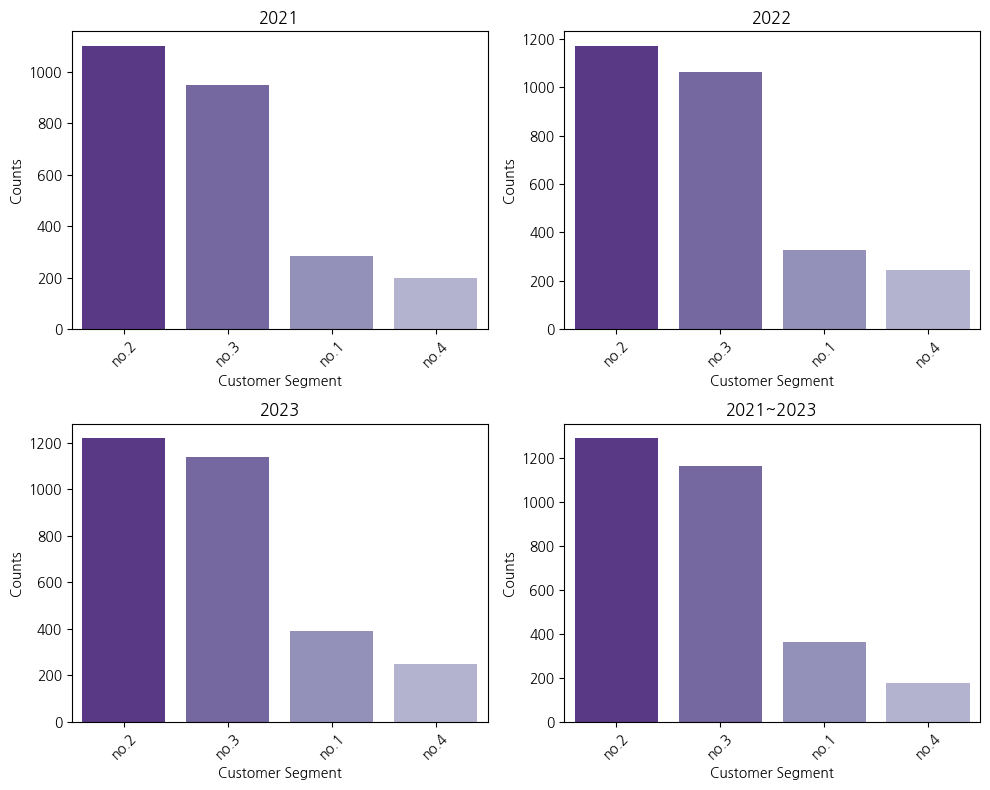

In [ ]:
palette = sns.color_palette('Purples')
palette.reverse()

# subplot을 이용하여 2x2 형태의 그래프를 만듭니다.
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# 각각의 subplot에 바 그래프를 그립니다.
sns.barplot(data=segment_counts_sorted_df_21, x='Segment', y='Count', palette=palette, ax=axes[0, 0])
sns.barplot(data=segment_counts_sorted_df_22, x='Segment', y='Count', palette=palette, ax=axes[0, 1])
sns.barplot(data=segment_counts_sorted_df_23, x='Segment', y='Count', palette=palette, ax=axes[1, 0])
sns.barplot(data=segment_counts_sorted_df, x='Segment', y='Count', palette=palette, ax=axes[1, 1])

# 각 subplot에 제목과 축 레이블을 추가합니다.
axes[0, 0].set_title('2021')
axes[0, 0].set_xlabel('Customer Segment')
axes[0, 0].set_ylabel('Counts')
axes[0, 0].tick_params(axis='x', rotation=45)

axes[0, 1].set_title('2022')
axes[0, 1].set_xlabel('Customer Segment')
axes[0, 1].set_ylabel('Counts')
axes[0, 1].tick_params(axis='x', rotation=45)

axes[1, 0].set_title('2023')
axes[1, 0].set_xlabel('Customer Segment')
axes[1, 0].set_ylabel('Counts')
axes[1, 0].tick_params(axis='x', rotation=45)

axes[1, 1].set_title('2021~2023')
axes[1, 1].set_xlabel('Customer Segment')
axes[1, 1].set_ylabel('Counts')
axes[1, 1].tick_params(axis='x', rotation=45)

# 그래프 간 간격 조정
plt.tight_layout()

# 전체 figure를 표시합니다.
plt.show()

비율에 큰 차이가 없어보인다. 누적막대그래프로 한번 더 확인.

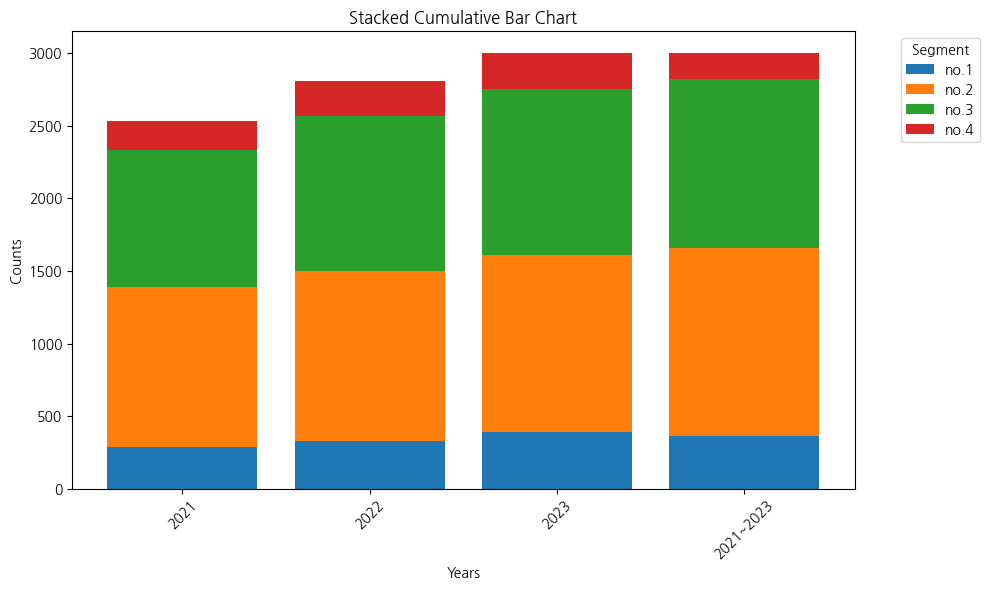

In [ ]:
total_segment_counts = pd.merge(segment_counts_sorted_df_21[['Segment','Count']], segment_counts_sorted_df_22[['Segment','Count']], on='Segment', how='left', suffixes=('_21', '_22'))
total_segment_counts = pd.merge(total_segment_counts[['Segment','Count_21','Count_22']], segment_counts_sorted_df_23[['Segment','Count']], on='Segment', how='left')
total_segment_counts = total_segment_counts.rename(columns={"Count": "Count_23"})
total_segment_counts = pd.merge(total_segment_counts[['Segment','Count_21','Count_22','Count_23']], segment_counts_sorted_df[['Segment','Count']], on='Segment', how='left')
total_segment_counts.sort_values(by='Segment', inplace=True)

# 누적 막대 그래프 그리기
plt.figure(figsize=(10, 6))

# 각 세그먼트를 누적하여 그래프에 추가
for i, segment in enumerate(total_segment_counts['Segment']):
    plt.bar(['2021', '2022', '2023', '2021~2023'], total_segment_counts.iloc[i, 1:], label=segment, bottom=total_segment_counts.iloc[:i, 1:].sum(axis=0))

plt.title('Stacked Cumulative Bar Chart')
plt.xlabel('Years')
plt.ylabel('Counts')
plt.legend(title='Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


비슷하네요.. 비율그래프로 재확인

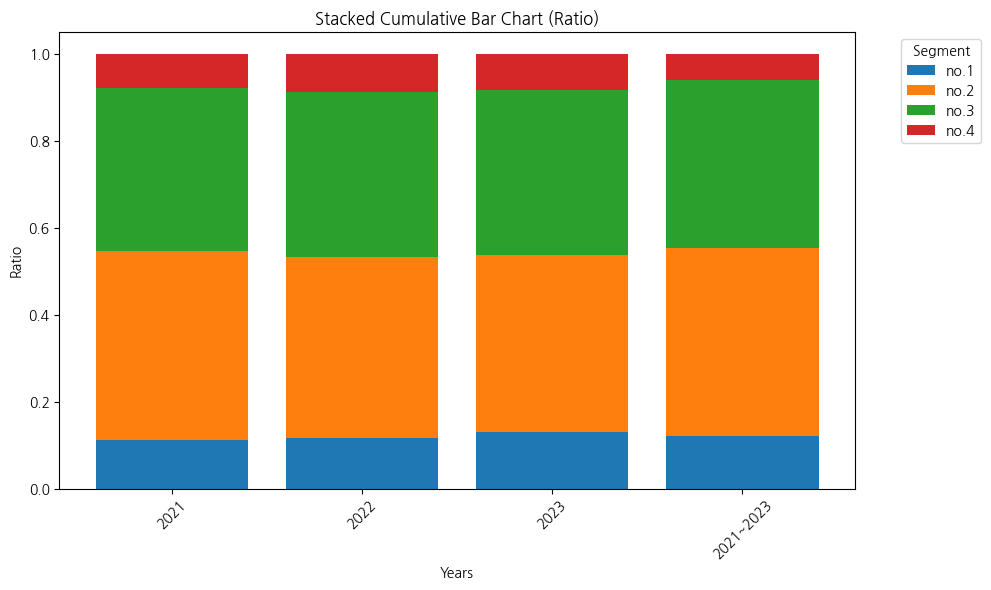

In [ ]:

# 비율 계산
total_segment_counts_ratio = total_segment_counts.copy()
total_segment_counts_ratio[['Count_21', 'Count_22', 'Count_23', 'Count']] = total_segment_counts_ratio[['Count_21', 'Count_22', 'Count_23', 'Count']] / total_segment_counts_ratio[['Count_21', 'Count_22', 'Count_23', 'Count']].sum()

# 누적 막대 그래프 그리기
plt.figure(figsize=(10, 6))

# 각 세그먼트를 누적하여 그래프에 추가
for i, segment in enumerate(total_segment_counts_ratio['Segment']):
    plt.bar(['2021', '2022', '2023', '2021~2023'], total_segment_counts_ratio.iloc[i, 1:], label=segment, bottom=total_segment_counts_ratio.iloc[:i, 1:].sum(axis=0))

plt.title('Stacked Cumulative Bar Chart (Ratio)')
plt.xlabel('Years')
plt.ylabel('Ratio')
plt.legend(title='Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



똑같네요...

In [ ]:
total_segment_counts_ratio

,Segment,Count_21,Count_22,Count_23,Count
2,no.1,0.112164,0.116684,0.130333,0.121667
0,no.2,0.435229,0.417289,0.407000,0.431000
1,no.3,0.374013,0.378869,0.379667,0.388667
3,no.4,0.078594,0.087158,0.083000,0.058667


### 연도별 rfm 병합

In [ ]:
merge_rfm = pd.merge(rfm_data_21[['idUser','Customer_Segment_21']], rfm_data_22[['idUser','Customer_Segment_22']], on='idUser', how='left')
merge_rfm = pd.merge(merge_rfm[['idUser','Customer_Segment_21','Customer_Segment_22']], rfm_data_23[['idUser','Customer_Segment_23']], on='idUser', how='left')
merge_rfm = pd.merge(merge_rfm[['idUser','Customer_Segment_21','Customer_Segment_22','Customer_Segment_23']], rfm_data[['idUser','Customer_Segment']], on='idUser', how='left')

In [ ]:
#pd.set_option('display.max_rows', None)
merge_rfm[merge_rfm.isna().any(axis=1)]
#pd.reset_option('display.max_rows')

,idUser,Customer_Segment_21,Customer_Segment_22,Customer_Segment_23,Customer_Segment
2,U10004,no.2,NaN,no.4,no.4
29,U10036,no.1,NaN,no.3,no.4
39,U10049,no.3,NaN,no.2,no.3
59,U10073,no.2,NaN,no.2,no.4
77,U10092,no.2,NaN,no.3,no.3
...,...,...,...,...,...
2463,U12921,no.3,NaN,no.1,no.3
2477,U12935,no.3,NaN,no.2,no.3
2478,U12936,no.1,NaN,no.2,no.3
2490,U12951,no.4,NaN,no.3,no.3


왜 2022에만 NaN값이? -> 왜 2022에만 주문을 하지 않은 고객이 많을까요?  
(2021, 2023년엔 그런 고객 없음)

### 고객별 등급 변동지수

고객별 등급 변동지수를 알아보기 위해,  
no.1 -> 1 , no.2 -> 2 , no.3 -> 3 , no.4 -> 4 로 변환 후 분산 구하기  
분산값이 클 수록 등급에 변화가 많이 있다.  
NaN 값은 5 로 대체. (주문이 없는 고객이였으니 임의로 no.5라고 설정)

In [ ]:
merge_rfm_var = merge_rfm.replace('no.', '', regex=True)
merge_rfm_var.drop('Customer_Segment', axis=1, inplace=True)

# NaN 값을 0으로 바꾸고 int 형으로 변환
merge_rfm_var[['Customer_Segment_21', 'Customer_Segment_22', 'Customer_Segment_23']] = merge_rfm_var[['Customer_Segment_21', 'Customer_Segment_22', 'Customer_Segment_23']].fillna(5).astype(int)

merge_rfm_var

,idUser,Customer_Segment_21,Customer_Segment_22,Customer_Segment_23
0,U10001,2,2,3
1,U10002,2,3,3
2,U10004,2,5,4
3,U10005,2,2,2
4,U10006,3,2,1
...,...,...,...,...
2527,U12995,2,2,2
2528,U12997,2,3,1
2529,U12998,4,3,3
2530,U12999,2,3,2


In [ ]:
# 변동 지수 계산 함수 정의
def variability_index(row):
    # 해당 유저의 Customer Segment 데이터 추출
    segments = row[['Customer_Segment_21', 'Customer_Segment_22', 'Customer_Segment_23']]

    # 표준편차와 평균 계산
    std_dev = np.std(segments)
    mean = np.mean(segments)

    # 변동 지수 계산
    return (std_dev / mean).round(3)

# 각 유저의 변동 지수 계산
merge_rfm_var['Variability'] = merge_rfm_var.apply(variability_index, axis=1)

merge_rfm_var.sort_values('Variability', ascending=False).head(10)

,idUser,Customer_Segment_21,Customer_Segment_22,Customer_Segment_23,Variability
558,U10669,1,5,1,0.808
290,U10345,1,5,1,0.808
178,U10211,1,5,1,0.808
1865,U12219,1,5,1,0.808
612,U10732,1,4,1,0.707
2346,U12791,4,1,1,0.707
2514,U12980,1,1,4,0.707
891,U11069,1,4,1,0.707
1797,U12134,1,1,4,0.707
878,U11056,1,1,4,0.707


4위까지 21년, 23년에는 no.1 이였지만 2022년에는 주문이 없는 고객. (왜지?)

In [ ]:
kurly[kurly['idUser']=='U10669'][['idUser','Year']].query('Year == 2022')

,idUser,Year


확인 결과 진짜 없다...

In [ ]:
merge_rfm_var.value_counts('Variability')

Variability
0.202    496
0.177    425
0.000    288
0.408    258
0.272    213
0.283    157
0.354    151
0.404    133
0.141     86
0.374     54
0.468     53
0.535     49
0.566     38
0.471     35
0.257     18
0.707     17
0.637     16
0.129     13
0.544     13
0.204      8
0.340      5
0.808      4
0.510      2
dtype: int64

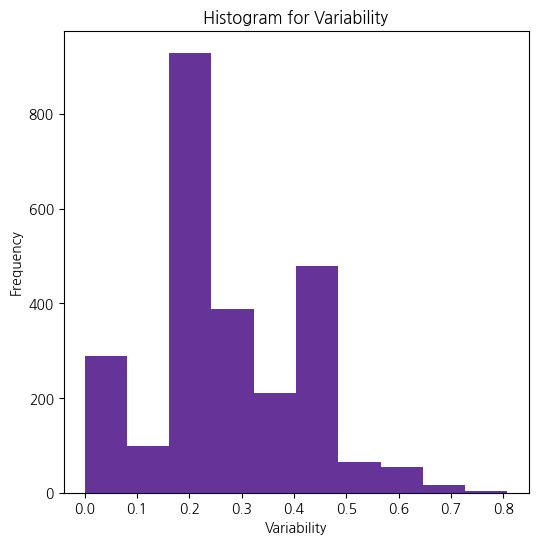

In [ ]:
# 'Variability' 열의 값이 0.2인 행들의 히스토그램 그리기
plt.figure(figsize=(6, 6))
plt.hist(merge_rfm_var['Variability'], bins=10, color='rebeccapurple')
plt.title('Histogram for Variability')
plt.xlabel('Variability')
plt.ylabel('Frequency')
plt.show()

변동이 큰 고객에게 맞춤 마케팅 제공하는 방법도 있을 것 같다.

In [ ]:

# MemberYN 별 Customer_Segment 빈도 계산
segment_counts = df.groupby(['Customer_Segment']).size().unstack()
# segment_counts_21 = df.groupby(['MemberYN', 'Customer_Segment_21']).size().unstack()
# segment_counts_22 = df.groupby(['MemberYN', 'Customer_Segment_22']).size().unstack()
# segment_counts_23 = df.groupby(['MemberYN', 'Customer_Segment_23']).size().unstack()

# subplot을 이용하여 2x2 형태의 그래프를 만듭니다.
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# 각각의 subplot에 바 그래프를 그립니다.
# segment_counts_21.plot(kind='bar', stacked=True, ax=axes[0, 0])
# segment_counts_22.plot(kind='bar', stacked=True, ax=axes[0, 1])
# segment_counts_23.plot(kind='bar', stacked=True, ax=axes[1, 0])
segment_counts.plot(kind='bar', stacked=True, ax=axes[1, 1])

<Axes: xlabel='MemberYN'>

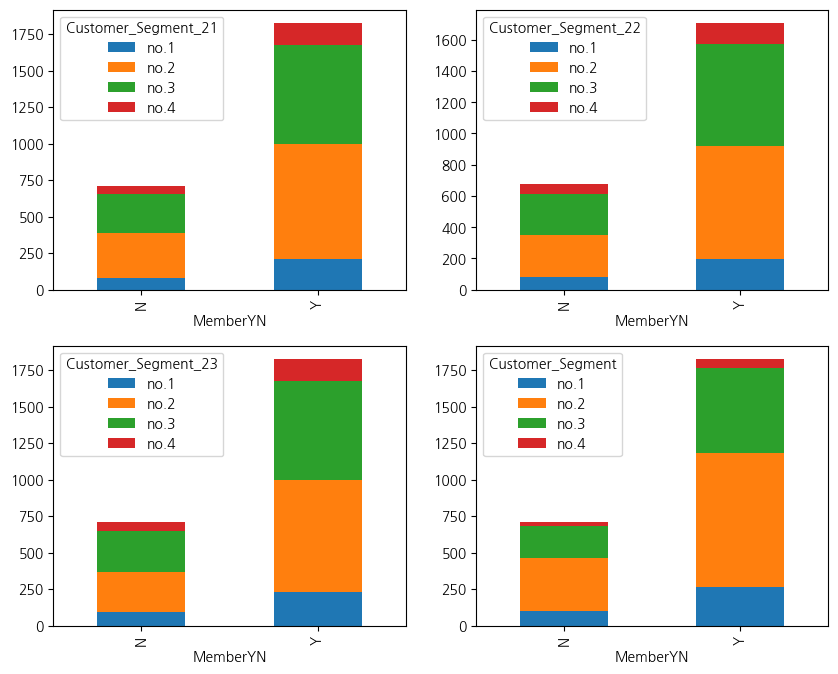

In [ ]:
df = pd.merge(kurly, merge_rfm[['idUser','Customer_Segment_21','Customer_Segment_22','Customer_Segment_23','Customer_Segment']], on='idUser', how='left')
df.drop_duplicates('idUser', inplace=True)

# MemberYN 별 Customer_Segment 빈도 계산
segment_counts = df.groupby(['MemberYN', 'Customer_Segment']).size().unstack()
segment_counts_21 = df.groupby(['MemberYN', 'Customer_Segment_21']).size().unstack()
segment_counts_22 = df.groupby(['MemberYN', 'Customer_Segment_22']).size().unstack()
segment_counts_23 = df.groupby(['MemberYN', 'Customer_Segment_23']).size().unstack()

# subplot을 이용하여 2x2 형태의 그래프를 만듭니다.
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# 각각의 subplot에 바 그래프를 그립니다.
segment_counts_21.plot(kind='bar', stacked=True, ax=axes[0, 0])
segment_counts_22.plot(kind='bar', stacked=True, ax=axes[0, 1])
segment_counts_23.plot(kind='bar', stacked=True, ax=axes[1, 0])
segment_counts.plot(kind='bar', stacked=True, ax=axes[1, 1])

멤버쉽별로 등급의 비율은 비슷함. 멤버쉽 유무는 영향을 주지 않는 것 같다.  

### kurly 데이터와 병합

In [ ]:
Kurly = pd.merge(kurly,merge_rfm,on='idUser')

In [ ]:
Kurly.head()

,idUser,idOrder,OrderDT,ItemCode,Price,DeliveryDT,Delay_YN,ItemLargeCode,ItemLargeName,ItemMiddleCode,...,Hour,CleanedItemName,TimeBetweenOrders,Combined,Weekday,WeekdayName,Customer_Segment_21,Customer_Segment_22,Customer_Segment_23,Customer_Segment
0,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L1-M12-S0070-1113,17030,2021-12-04 03:26:00,0,L1,가공식품,M12,...,20,이츠웰 후르츠칵테일 과일통조림 3k 슬라이스,3 days 09:06:40,"2030s, 여성",4,Friday,no.2,no.2,no.3,no.1
1,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L1-M15-S0140-1247,7680,2021-12-04 03:26:00,0,L1,가공식품,M15,...,20,베지가든 수제교자만두 매콤한 김치맛 720g 360gx2개입,3 days 09:06:40,"2030s, 여성",4,Friday,no.2,no.2,no.3,no.1
2,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L1-M23-S0580-1047,12420,2021-12-04 03:26:00,0,L1,가공식품,M23,...,20,매일유업 매일 상하치즈 피자용 모짜렐라 슈레드치즈 200gx5봉,3 days 09:06:40,"2030s, 여성",4,Friday,no.2,no.2,no.3,no.1
3,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L4-M12-S0640-1010,6250,2021-12-04 03:26:00,0,L4,신선식품,M12,...,20,계양구 배달 싱싱한 방울토마토 750g 작전 과일나라,3 days 09:06:40,"2030s, 여성",4,Friday,no.2,no.2,no.3,no.1
4,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L4-M17-S0130-1018,14450,2021-12-04 03:26:00,0,L4,신선식품,M17,...,20,낙지호롱 900g 20 25개 낙지꼬치구이 냉동낙지 양념소스70gx1팩 제공,3 days 09:06:40,"2030s, 여성",4,Friday,no.2,no.2,no.3,no.1


In [ ]:
Kurly.columns

Index(['idUser', 'idOrder', 'OrderDT', 'ItemCode', 'Price', 'DeliveryDT',
       'Delay_YN', 'ItemLargeCode', 'ItemLargeName', 'ItemMiddleCode',
       'ItemMiddleName', 'ItemSmallCode', 'ItemSmallName', 'ItemName',
       'Gender', 'Age', 'FamilyCount', 'MemberYN', 'AgeGroup', 'Date', 'Year',
       'Month', 'Day', 'Hour', 'CleanedItemName', 'TimeBetweenOrders',
       'Combined', 'Weekday', 'WeekdayName', 'Customer_Segment_21',
       'Customer_Segment_22', 'Customer_Segment_23', 'Customer_Segment'],
      dtype='object')

### 고객등급과 다른 변수들과의 관계

#### 고객등급별 고객정보

In [ ]:
Kurly_segment_user = Kurly[['idUser','Gender', 'Age', 'FamilyCount', 'MemberYN', 'AgeGroup','Combined','Customer_Segment']]
Kurly_segment_user.head()

,idUser,Gender,Age,FamilyCount,MemberYN,AgeGroup,Combined,Customer_Segment
0,U10001,여성,26,2,Y,2030s,"2030s, 여성",no.1
1,U10001,여성,26,2,Y,2030s,"2030s, 여성",no.1
2,U10001,여성,26,2,Y,2030s,"2030s, 여성",no.1
3,U10001,여성,26,2,Y,2030s,"2030s, 여성",no.1
4,U10001,여성,26,2,Y,2030s,"2030s, 여성",no.1


<ipython-input-114-2356fa629281>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df1, x='Combined', y='Count', palette=palette)
<ipython-input-114-2356fa629281>:11: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.barplot(data=df1, x='Combined', y='Count', palette=palette)
<ipython-input-114-2356fa629281>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df2, x='AgeGroup', y='Count', palette=palette)
<ipython-input-114-2356fa629281>:21: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.barplot(data=df2, x='AgeGroup', y='Count', palette=palette)
<ipython-input-114-2356fa629281>:3

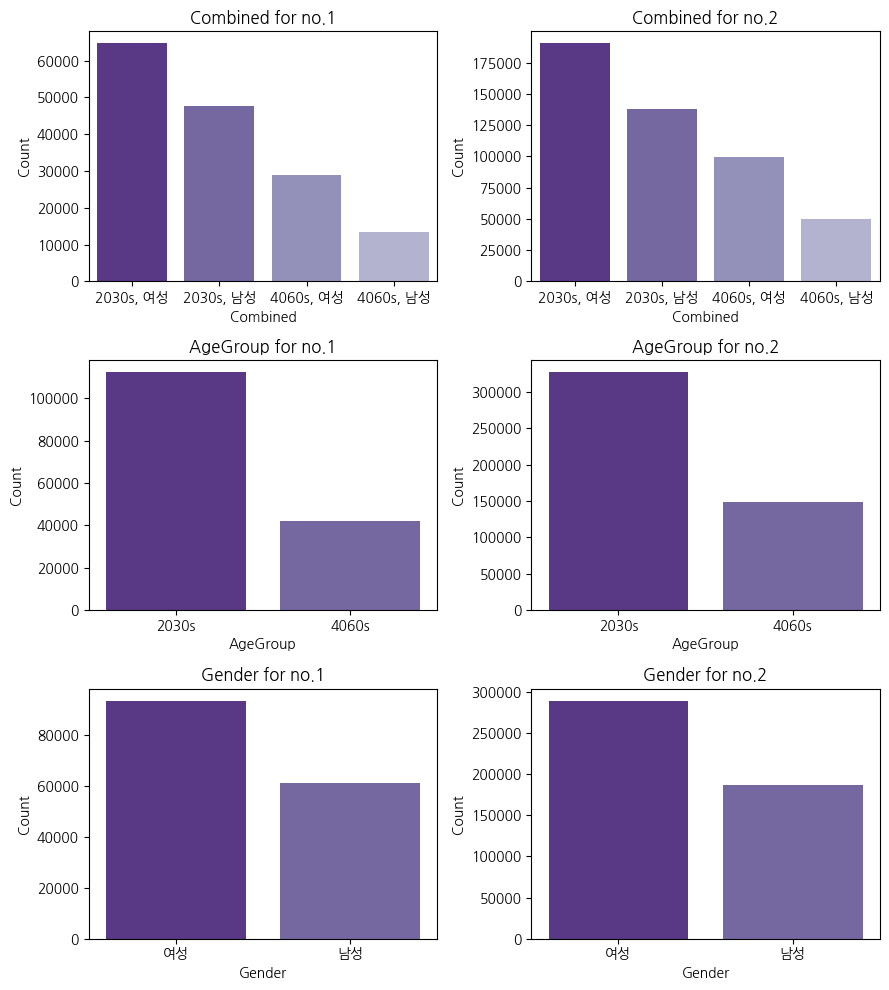

In [ ]:
plt.figure(figsize=(9, 10))  # 전체 그래프의 크기 설정

palette = sns.color_palette('Purples')  # 팔레트 설정
palette.reverse()  # 팔레트 순서 뒤집기

# 첫 번째 subplot
plt.subplot(3, 2, 1)
df1 = pd.DataFrame(Kurly_segment_user[Kurly_segment_user['Customer_Segment']=='no.1'].value_counts('Combined'))
df1 = df1.rename(columns={0: 'Count'})

sns.barplot(data=df1, x='Combined', y='Count', palette=palette)
plt.title('Combined for no.1')
plt.xlabel('Combined')
plt.ylabel('Count')

# 두 번째 subplot
plt.subplot(3, 2, 3)
df2 = pd.DataFrame(Kurly_segment_user[Kurly_segment_user['Customer_Segment']=='no.1'].value_counts('AgeGroup'))
df2 = df2.rename(columns={0: 'Count'})

sns.barplot(data=df2, x='AgeGroup', y='Count', palette=palette)
plt.title('AgeGroup for no.1')
plt.xlabel('AgeGroup')
plt.ylabel('Count')

# 세 번째 subplot
plt.subplot(3, 2, 5)
df3 = pd.DataFrame(Kurly_segment_user[Kurly_segment_user['Customer_Segment']=='no.1'].value_counts('Gender'))
df3 = df3.rename(columns={0: 'Count'})

sns.barplot(data=df3, x='Gender', y='Count', palette=palette)
plt.title('Gender for no.1')
plt.xlabel('Gender')
plt.ylabel('Count')

# 네 번째 subplot
plt.subplot(3, 2, 2)
df1 = pd.DataFrame(Kurly_segment_user[Kurly_segment_user['Customer_Segment']=='no.2'].value_counts('Combined'))
df1 = df1.rename(columns={0: 'Count'})

sns.barplot(data=df1, x='Combined', y='Count', palette=palette)
plt.title('Combined for no.2')
plt.xlabel('Combined')
plt.ylabel('Count')

# 다섯 번째 subplot
plt.subplot(3, 2, 4)
df2 = pd.DataFrame(Kurly_segment_user[Kurly_segment_user['Customer_Segment']=='no.2'].value_counts('AgeGroup'))
df2 = df2.rename(columns={0: 'Count'})

sns.barplot(data=df2, x='AgeGroup', y='Count', palette=palette)
plt.title('AgeGroup for no.2')
plt.xlabel('AgeGroup')
plt.ylabel('Count')

# 여섯 번째 subplot
plt.subplot(3, 2, 6)
df3 = pd.DataFrame(Kurly_segment_user[Kurly_segment_user['Customer_Segment']=='no.2'].value_counts('Gender'))
df3 = df3.rename(columns={0: 'Count'})

sns.barplot(data=df3, x='Gender', y='Count', palette=palette)
plt.title('Gender for no.2')
plt.xlabel('Gender')
plt.ylabel('Count')

plt.tight_layout()  # 그래프 간격 조정
plt.show()


<ipython-input-140-5152c2ee548a>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df1, x='Combined', y='Count', palette=palette)
<ipython-input-140-5152c2ee548a>:11: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.barplot(data=df1, x='Combined', y='Count', palette=palette)
<ipython-input-140-5152c2ee548a>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df2, x='AgeGroup', y='Count', palette=palette)
<ipython-input-140-5152c2ee548a>:21: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.barplot(data=df2, x='AgeGroup', y='Count', palette=palette)
<ipython-input-140-5152c2ee548a>:3

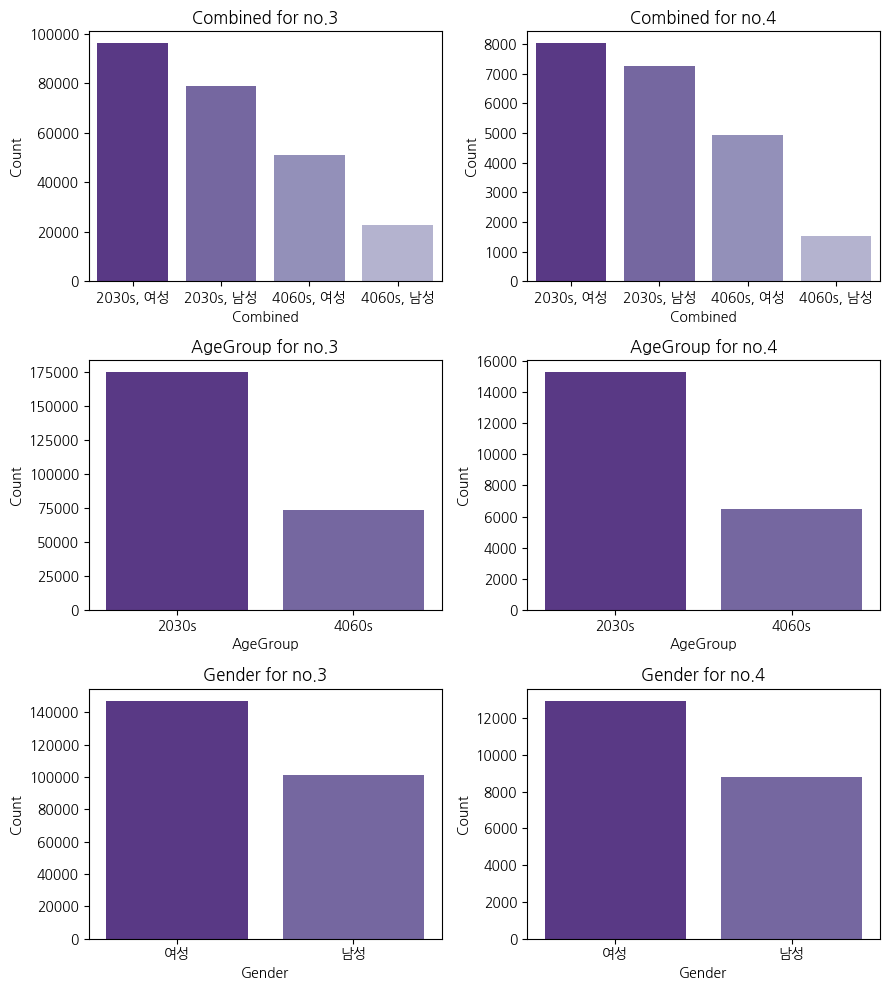

In [ ]:
plt.figure(figsize=(9, 10))  # 전체 그래프의 크기 설정

palette = sns.color_palette('Purples')  # 팔레트 설정
palette.reverse()  # 팔레트 순서 뒤집기

# 첫 번째 subplot
plt.subplot(3, 2, 1)
df1 = pd.DataFrame(Kurly_segment_user[Kurly_segment_user['Customer_Segment']=='no.3'].value_counts('Combined'))
df1 = df1.rename(columns={0: 'Count'})

sns.barplot(data=df1, x='Combined', y='Count', palette=palette)
plt.title('Combined for no.3')
plt.xlabel('Combined')
plt.ylabel('Count')

# 두 번째 subplot
plt.subplot(3, 2, 3)
df2 = pd.DataFrame(Kurly_segment_user[Kurly_segment_user['Customer_Segment']=='no.3'].value_counts('AgeGroup'))
df2 = df2.rename(columns={0: 'Count'})

sns.barplot(data=df2, x='AgeGroup', y='Count', palette=palette)
plt.title('AgeGroup for no.3')
plt.xlabel('AgeGroup')
plt.ylabel('Count')

# 세 번째 subplot
plt.subplot(3, 2, 5)
df3 = pd.DataFrame(Kurly_segment_user[Kurly_segment_user['Customer_Segment']=='no.3'].value_counts('Gender'))
df3 = df3.rename(columns={0: 'Count'})

sns.barplot(data=df3, x='Gender', y='Count', palette=palette)
plt.title('Gender for no.3')
plt.xlabel('Gender')
plt.ylabel('Count')

# 네 번째 subplot
plt.subplot(3, 2, 2)
df1 = pd.DataFrame(Kurly_segment_user[Kurly_segment_user['Customer_Segment']=='no.4'].value_counts('Combined'))
df1 = df1.rename(columns={0: 'Count'})

sns.barplot(data=df1, x='Combined', y='Count', palette=palette)
plt.title('Combined for no.4')
plt.xlabel('Combined')
plt.ylabel('Count')

# 다섯 번째 subplot
plt.subplot(3, 2, 4)
df2 = pd.DataFrame(Kurly_segment_user[Kurly_segment_user['Customer_Segment']=='no.4'].value_counts('AgeGroup'))
df2 = df2.rename(columns={0: 'Count'})

sns.barplot(data=df2, x='AgeGroup', y='Count', palette=palette)
plt.title('AgeGroup for no.4')
plt.xlabel('AgeGroup')
plt.ylabel('Count')

# 여섯 번째 subplot
plt.subplot(3, 2, 6)
df3 = pd.DataFrame(Kurly_segment_user[Kurly_segment_user['Customer_Segment']=='no.4'].value_counts('Gender'))
df3 = df3.rename(columns={0: 'Count'})

sns.barplot(data=df3, x='Gender', y='Count', palette=palette)
plt.title('Gender for no.4')
plt.xlabel('Gender')
plt.ylabel('Count')

plt.tight_layout()  # 그래프 간격 조정
plt.show()


#### 고객등급별 선호 식품

In [ ]:
Kurly_segment_item = Kurly[['idUser','idOrder' ,'ItemLargeName','ItemMiddleName','ItemSmallName','Customer_Segment']]
Kurly_segment_item.head()

,idUser,idOrder,ItemLargeName,ItemMiddleName,ItemSmallName,Customer_Segment
0,U10001,U10001-O2021-1001,가공식품,과일,과일,no.1
1,U10001,U10001-O2021-1001,가공식품,냉동,냉동,no.1
2,U10001,U10001-O2021-1001,가공식품,축산,치즈,no.1
3,U10001,U10001-O2021-1001,신선식품,과일,토마,no.1
4,U10001,U10001-O2021-1001,신선식품,수산,낙지,no.1


In [ ]:
# Customer_Segment 별로 가장 많이 나오는 ItemLargeName, ItemMiddleName, ItemSmallName 찾기
most_common_items = Kurly_segment_item.groupby('Customer_Segment').agg({
    'ItemLargeName': pd.Series.mode,
    'ItemMiddleName': pd.Series.mode,
    'ItemSmallName': pd.Series.mode
})
most_common_items

,ItemLargeName,ItemMiddleName,ItemSmallName
Customer_Segment,,,
no.1,신선식품,과일,냉동
no.2,신선식품,과일,냉동
no.3,신선식품,과일,냉동
no.4,신선식품,과일,냉동


<ipython-input-122-5e156cbdfc96>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df1, x='ItemLargeName', y='Count', palette=palette)
<ipython-input-122-5e156cbdfc96>:11: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.barplot(data=df1, x='ItemLargeName', y='Count', palette=palette)
<ipython-input-122-5e156cbdfc96>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df2, x='ItemMiddleName', y='Count', palette=palette)
<ipython-input-122-5e156cbdfc96>:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effe

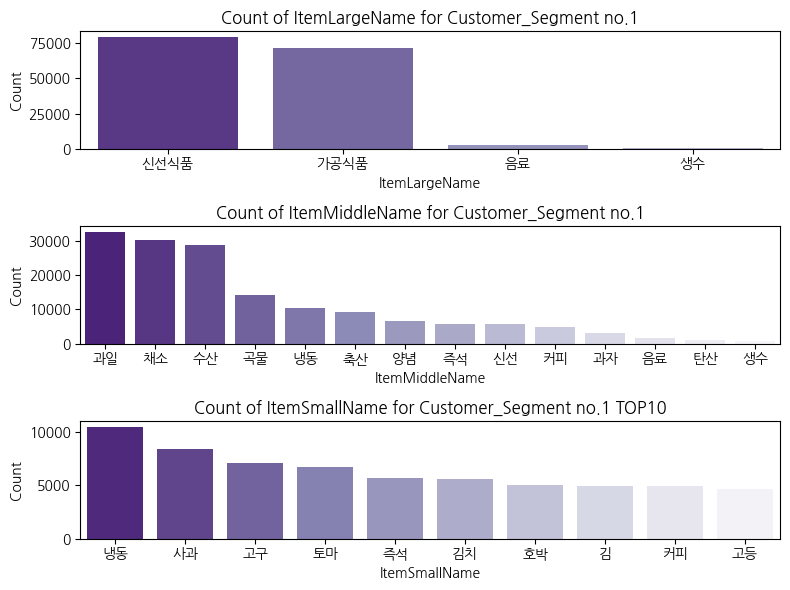

In [ ]:
plt.figure(figsize=(8, 6))

# 첫 번째 subplot
plt.subplot(3, 1, 1)
df1 = pd.DataFrame(Kurly_segment_item[Kurly_segment_item['Customer_Segment']=='no.1'].value_counts('ItemLargeName'))
df1 = df1.rename(columns={0: 'Count'})

palette = sns.color_palette('Purples')
palette.reverse()

sns.barplot(data=df1, x='ItemLargeName', y='Count', palette=palette)
plt.title('Count of ItemLargeName for Customer_Segment no.1')
plt.xlabel('ItemLargeName')
plt.ylabel('Count')

# 두 번째 subplot
plt.subplot(3, 1, 2)
df2 = pd.DataFrame(Kurly_segment_item[Kurly_segment_item['Customer_Segment']=='no.1'].value_counts('ItemMiddleName'))
df2 = df2.rename(columns={0: 'Count'})

palette = sns.color_palette('Purples', len(df2))
palette.reverse()

sns.barplot(data=df2, x='ItemMiddleName', y='Count', palette=palette)
plt.title('Count of ItemMiddleName for Customer_Segment no.1')
plt.xlabel('ItemMiddleName')
plt.ylabel('Count')

# 세 번째 subplot
plt.subplot(3, 1, 3)
df3 = pd.DataFrame(Kurly_segment_item[Kurly_segment_item['Customer_Segment']=='no.1'].value_counts('ItemSmallName')).head(10)
df3 = df3.rename(columns={0: 'Count'})

palette = sns.color_palette('Purples', len(df3))
palette.reverse()

sns.barplot(data=df3, x='ItemSmallName', y='Count', palette=palette)
plt.title('Count of ItemSmallName for Customer_Segment no.1 TOP10')
plt.xlabel('ItemSmallName')
plt.ylabel('Count')

plt.tight_layout()  # 그래프 간격 조정
plt.show()

<ipython-input-119-b4725028064d>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df4, x='ItemLargeName', y='Count', palette=palette)
<ipython-input-119-b4725028064d>:11: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.barplot(data=df4, x='ItemLargeName', y='Count', palette=palette)
<ipython-input-119-b4725028064d>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df5, x='ItemMiddleName', y='Count', palette=palette)
<ipython-input-119-b4725028064d>:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effe

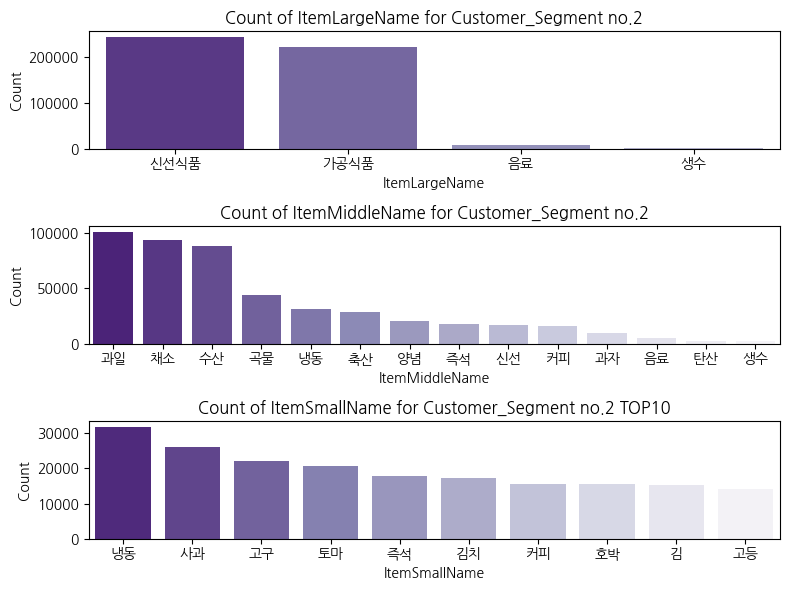

In [ ]:
plt.figure(figsize=(8, 6))

# 첫 번째 subplot
plt.subplot(3, 1, 1)
df4 = pd.DataFrame(Kurly_segment_item[Kurly_segment_item['Customer_Segment']=='no.2'].value_counts('ItemLargeName'))
df4 = df4.rename(columns={0: 'Count'})

palette = sns.color_palette('Purples')
palette.reverse()

sns.barplot(data=df4, x='ItemLargeName', y='Count', palette=palette)
plt.title('Count of ItemLargeName for Customer_Segment no.2')
plt.xlabel('ItemLargeName')
plt.ylabel('Count')

# 두 번째 subplot
plt.subplot(3, 1, 2)
df5 = pd.DataFrame(Kurly_segment_item[Kurly_segment_item['Customer_Segment']=='no.2'].value_counts('ItemMiddleName'))
df5 = df5.rename(columns={0: 'Count'})

palette = sns.color_palette('Purples', len(df5))
palette.reverse()

sns.barplot(data=df5, x='ItemMiddleName', y='Count', palette=palette)
plt.title('Count of ItemMiddleName for Customer_Segment no.2')
plt.xlabel('ItemMiddleName')
plt.ylabel('Count')

# 세 번째 subplot
plt.subplot(3, 1, 3)
df6 = pd.DataFrame(Kurly_segment_item[Kurly_segment_item['Customer_Segment']=='no.2'].value_counts('ItemSmallName')).head(10)
df6 = df6.rename(columns={0: 'Count'})

palette = sns.color_palette('Purples', len(df6))
palette.reverse()

sns.barplot(data=df6, x='ItemSmallName', y='Count', palette=palette)
plt.title('Count of ItemSmallName for Customer_Segment no.2 TOP10')
plt.xlabel('ItemSmallName')
plt.ylabel('Count')

plt.tight_layout()  # 그래프 간격 조정
plt.show()


<ipython-input-120-f604f191e9c0>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df7, x='ItemLargeName', y='Count', palette=palette)
<ipython-input-120-f604f191e9c0>:11: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.barplot(data=df7, x='ItemLargeName', y='Count', palette=palette)
<ipython-input-120-f604f191e9c0>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df8, x='ItemMiddleName', y='Count', palette=palette)
<ipython-input-120-f604f191e9c0>:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effe

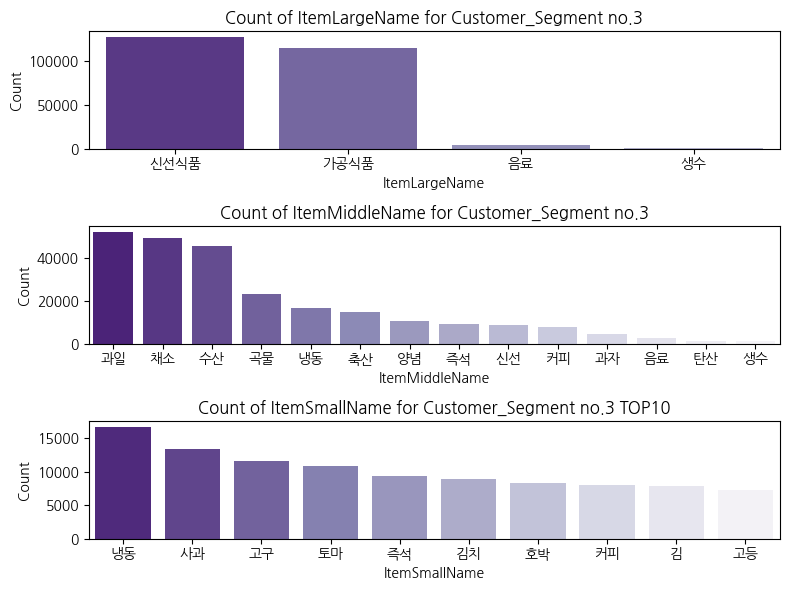

In [ ]:
plt.figure(figsize=(8, 6))

# 첫 번째 subplot
plt.subplot(3, 1, 1)
df7 = pd.DataFrame(Kurly_segment_item[Kurly_segment_item['Customer_Segment']=='no.3'].value_counts('ItemLargeName'))
df7 = df7.rename(columns={0: 'Count'})

palette = sns.color_palette('Purples')
palette.reverse()

sns.barplot(data=df7, x='ItemLargeName', y='Count', palette=palette)
plt.title('Count of ItemLargeName for Customer_Segment no.3')
plt.xlabel('ItemLargeName')
plt.ylabel('Count')

# 두 번째 subplot
plt.subplot(3, 1, 2)
df8 = pd.DataFrame(Kurly_segment_item[Kurly_segment_item['Customer_Segment']=='no.3'].value_counts('ItemMiddleName'))
df8 = df8.rename(columns={0: 'Count'})

palette = sns.color_palette('Purples', len(df8))
palette.reverse()

sns.barplot(data=df8, x='ItemMiddleName', y='Count', palette=palette)
plt.title('Count of ItemMiddleName for Customer_Segment no.3')
plt.xlabel('ItemMiddleName')
plt.ylabel('Count')

# 세 번째 subplot
plt.subplot(3, 1, 3)
df9 = pd.DataFrame(Kurly_segment_item[Kurly_segment_item['Customer_Segment']=='no.3'].value_counts('ItemSmallName')).head(10)
df9 = df9.rename(columns={0: 'Count'})

palette = sns.color_palette('Purples', len(df9))
palette.reverse()

sns.barplot(data=df9, x='ItemSmallName', y='Count', palette=palette)
plt.title('Count of ItemSmallName for Customer_Segment no.3 TOP10')
plt.xlabel('ItemSmallName')
plt.ylabel('Count')

plt.tight_layout()  # 그래프 간격 조정
plt.show()


<ipython-input-121-50f4fc2d525d>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df10, x='ItemLargeName', y='Count', palette=palette)
<ipython-input-121-50f4fc2d525d>:11: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.barplot(data=df10, x='ItemLargeName', y='Count', palette=palette)
<ipython-input-121-50f4fc2d525d>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df11, x='ItemMiddleName', y='Count', palette=palette)
<ipython-input-121-50f4fc2d525d>:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same e

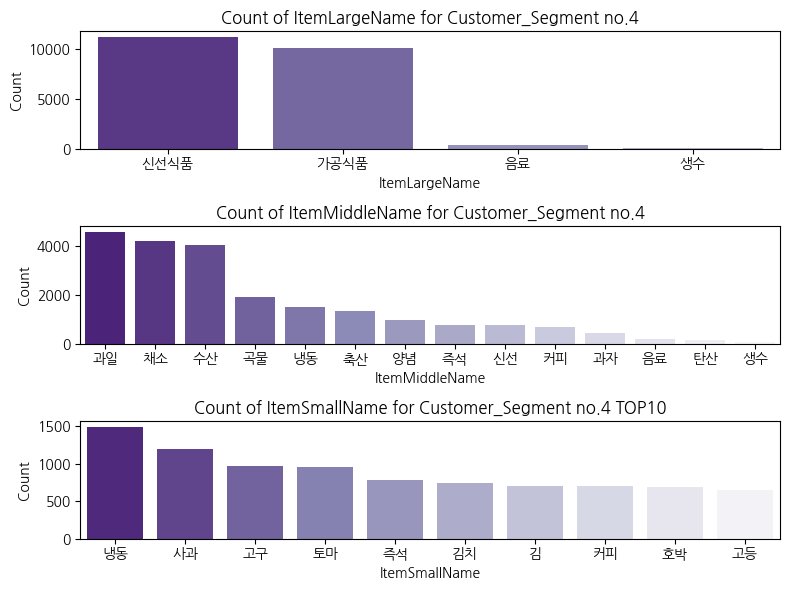

In [ ]:
plt.figure(figsize=(8, 6))

# 첫 번째 subplot
plt.subplot(3, 1, 1)
df10 = pd.DataFrame(Kurly_segment_item[Kurly_segment_item['Customer_Segment']=='no.4'].value_counts('ItemLargeName'))
df10 = df10.rename(columns={0: 'Count'})

palette = sns.color_palette('Purples')
palette.reverse()

sns.barplot(data=df10, x='ItemLargeName', y='Count', palette=palette)
plt.title('Count of ItemLargeName for Customer_Segment no.4')
plt.xlabel('ItemLargeName')
plt.ylabel('Count')

# 두 번째 subplot
plt.subplot(3, 1, 2)
df11 = pd.DataFrame(Kurly_segment_item[Kurly_segment_item['Customer_Segment']=='no.4'].value_counts('ItemMiddleName'))
df11 = df11.rename(columns={0: 'Count'})

palette = sns.color_palette('Purples', len(df11))
palette.reverse()

sns.barplot(data=df11, x='ItemMiddleName', y='Count', palette=palette)
plt.title('Count of ItemMiddleName for Customer_Segment no.4')
plt.xlabel('ItemMiddleName')
plt.ylabel('Count')

# 세 번째 subplot
plt.subplot(3, 1, 3)
df12 = pd.DataFrame(Kurly_segment_item[Kurly_segment_item['Customer_Segment']=='no.4'].value_counts('ItemSmallName')).head(10)
df12 = df12.rename(columns={0: 'Count'})

palette = sns.color_palette('Purples', len(df12))
palette.reverse()

sns.barplot(data=df12, x='ItemSmallName', y='Count', palette=palette)
plt.title('Count of ItemSmallName for Customer_Segment no.4 TOP10')
plt.xlabel('ItemSmallName')
plt.ylabel('Count')

plt.tight_layout()  # 그래프 간격 조정
plt.show()


count말고 순위를 넣고시ㅍ다

In [ ]:
merged_df1 = pd.concat([df1, df4, df7, df10], axis=1)
merged_df1.columns = [col + f'_no.{i}' for i, col in enumerate(merged_df.columns, start=1)]
merged_df1

,Count_no.1,Count_no.2,Count_no.3,Count_no.4
ItemLargeName,,,,
신선식품,79594,245053,128125,11188
가공식품,71798,222188,115693,10126
음료,2538,7613,3938,353
생수,650,2054,1033,89


In [ ]:
merged_df2 = pd.concat([df2, df5, df8, df11], axis=1)
merged_df2.columns = [col + f'_no.{i}' for i, col in enumerate(merged_df.columns, start=1)]
merged_df2

,Count_no.1_no.1,Count_no.2_no.2,Count_no.3_no.3,Count_no.4_no.4
ItemMiddleName,,,,
과일,32600,100987,52402,4589
채소,30292,93273,49449,4226
수산,28685,87990,45808,4067
곡물,14262,43840,23172,1924
냉동,10474,31732,16632,1491
축산,9145,28739,14799,1363
양념,6645,20676,10589,984
즉석,5729,17784,9306,784
신선,5626,17123,8892,749


In [ ]:
merged_df3 = pd.concat([df3, df6, df9, df12], axis=1)
merged_df3.columns = [col + f'_no.{i}' for i, col in enumerate(merged_df.columns, start=1)]
merged_df3

,Count_no.1_no.1,Count_no.2_no.2,Count_no.3_no.3,Count_no.4_no.4
ItemSmallName,,,,
냉동,10474,31732,16632,1491
사과,8365,26072,13380,1194
고구,7068,22179,11509,977
토마,6702,20610,10753,954
즉석,5729,17784,9306,784
김치,5626,17123,8892,749
호박,5022,15409,8338,689
김,4964,15262,7798,708
커피,4924,15674,8000,698
